## Finite precover decompositions

In [1331]:
from collections import deque
from transduction.fst import FST, eps

from transduction import (
    FST, EPSILON, PrecoverDecomp, examples, Precover,
    LazyRecursive, BuggyLazyRecursive, EagerNonrecursive, LazyPrecoverNFA, LazyNonrecursive,    
)
from transduction.util import display_table

SINK = "_|_"

A nice machine is given below

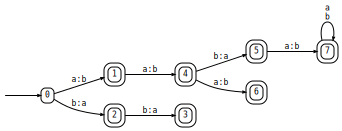

In [1332]:
fst = FST()
fst.add_arc(0,"a","b",1)
fst.add_arc(0,"b","a",2)
fst.add_arc(2,"b", "a", 3)

fst.add_arc(1,"a","b", 4)
fst.add_arc(4, "b","a", 5)
fst.add_arc(4,"a","b",6)
fst.add_arc(5, "a", "b", 7)
fst.add_arc(7,"a","a",7)
fst.add_arc(7,"b","b",7)

fst.I.add(0)
fst.F.update({1,2,3,4,5,6,7})
display(fst)

### Conditions for finite cover

For a given target string y, we want

1. A finite pre-image of y, i.e. no eps cycles

2. the end states after scanning y should be safe

#### No epsilon output loop check

In [1333]:
# strictly speaking we should ignore loops where there is no
# scanned input but we assume there are no such loops
# this can also be made target, since we target a given y


def _has_eps_cycle(fst, i, visited, recursion_stack):
    visited.add(i)
    recursion_stack.add(i)
    for _, b, j in fst.arcs(i):
        if b != eps:
            continue
        if j not in visited:
            if _has_eps_cycle(fst, j, visited, recursion_stack):
                return True
        elif j in recursion_stack:
            return True
    recursion_stack.remove(i)
    return False


def has_eps_cycle(fst):
    for state in fst.states:
        if _has_eps_cycle(fst, state, set(), set()):
            return True
    return False



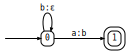

In [1334]:
fst_c = FST()
fst_c.add_arc(0,"a","b",1)
fst_c.add_arc(0,"b",eps,0)
fst_c.I.add(0)
fst_c.F.add(1)
display(fst_c)

In [1335]:
has_eps_cycle(fst_c)


True

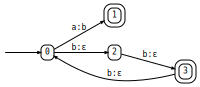

In [1336]:
fst_c = FST()
fst_c.add_arc(0,"a","b",1)
fst_c.add_arc(0,"b",eps,2)
fst_c.add_arc(2,"b",eps,3)
fst_c.add_arc(3,"b",eps,0)

fst_c.I.add(0)
fst_c.F.add(1)
fst_c.F.add(3)
display(fst_c)

In [1337]:
has_eps_cycle(fst_c)


True

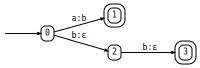

In [1338]:
fst_nc = FST()
fst_nc.add_arc(0,"a","b",1)
fst_nc.add_arc(0,"b",eps,2)
fst_nc.add_arc(2,"b",eps,3)
fst_nc.I.add(0)
fst_nc.F.add(1)
fst_nc.F.add(3)
display(fst_nc)
fst_no_cycle = fst_nc

In [1339]:
has_eps_cycle(fst_nc)


False

In [1340]:
has_eps_cycle(fst)

False

#### Universality check

In [1341]:
def is_universal(fst, i):
    # same as on class
    i_fst = fst.spawn(keep_arcs=True, keep_stop=True)
    i_fst.add_I(i)
    i_fsa = i_fst.project(0)
    i_dfa = i_fsa.min()
    if len(i_dfa.states) != 1:
        return False
    [i] = i_dfa.states
    for a in fst.A:
        if set(i_dfa.arcs(i, a)) != {i}:
            return False
    return True


In [1342]:
for i in fst_nc.states:
    print(i, is_universal(fst_nc, i))

0 False
1 False
2 False
3 False


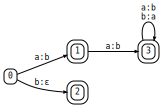

In [1343]:
fst_u = FST()
fst_u.add_arc(0,"a","b",1)
fst_u.add_arc(0,"b",eps,2)
fst_u.add_arc(1, "a", "b",3)
fst_u.add_arc(3, "b", "a",3)
fst_u.add_arc(3, "a", "b",3)
fst_u.F.add(1)
fst_u.F.add(2)
fst_u.F.add(3)
display(fst_u)

In [1344]:
for i in fst_u.states:
    print(i, is_universal(fst_u, i))

0 False
1 False
2 False
3 True


#### No input scanning cycles

In [1345]:
def has_input_cycle(fst):
    sccs = fst.strongly_connected_components()

    comp_id = {}
    for cid, comp in enumerate(sccs):
        for q in comp:
            comp_id[q] = cid

    n = len(sccs)
    size = [len(comp) for comp in sccs]
    has_self_loop = [False] * n
    has_non_eps_arc = [False] * n

    for i in fst.states:
        cid = comp_id[i]
        for a, _, j in fst.arcs(i):
            if comp_id[j] != cid:
                continue

            if i == j:
                has_self_loop[cid] = True
            if a != eps:
                has_non_eps_arc[cid] = True

    # SCC has an input-scanning cycle if actually has a cycle and has at least one non-epsilon arc
    for cid in range(n):
        if has_non_eps_arc[cid] and (size[cid] > 1 or has_self_loop[cid]):
            return True

    return False


In [1346]:
has_input_cycle(fst)


True

In [1347]:
has_input_cycle(fst_nc)


False

In [1348]:
def has_input_cycle_on_path(fst, path):
    first = path[0]

    if isinstance(first, tuple) and len(first) == 4:
        start_state = path[0][0]
        end_state = path[-1][3]
    else:
        start_state = path[0]
        end_state = path[-1]

    sub = fst.spawn(keep_arcs=True)
    sub.I.clear()
    sub.F.clear()
    sub.add_I(start_state)
    sub.add_F(end_state)
    trimmed = sub.trim()

    return has_input_cycle(trimmed)

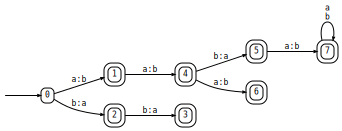

In [1349]:
display(fst)


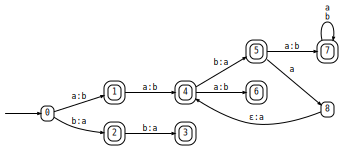

In [1350]:
fst_loop = fst.spawn(keep_init=True, keep_stop=True, keep_arcs=True)
fst_loop.add_arc(5,"a","a", 8)
fst_loop.add_arc(8, eps, "a", 4)
display(fst_loop)

In [1351]:
assert has_input_cycle(fst_loop)
path = [1,4,5]
assert has_input_cycle_on_path(fst_loop, path)

path = [0,2,3]
assert not has_input_cycle_on_path(fst_loop, path)

#### Finite closure check

In [1352]:
def has_fc(fst, i):
    i_fst = fst.spawn(keep_arcs=True, keep_stop=True, keep_init=False)
    i_fst.add_I(i)
    i_fst = i_fst.trim()
    return not has_input_cycle(i_fst)


In [1353]:
for i in [1,4,5,7]:
   assert not has_fc(fst_loop, i)

for i in [2, 3, 6]:
    assert has_fc(fst_loop, i)

#### Getting the emitting paths

In [1385]:
def paths_emitting(fst, y, max_paths=None, only_final=False):
    paths = []

    def dfs(state, pos, path, seen):
        if pos == len(y):
            if not only_final or fst.is_final(state):
                paths.append(list(path))
                if max_paths is not None and len(paths) >= max_paths:
                    return

        if max_paths is not None and len(paths) >= max_paths:
            return

        for a, b, j in fst.arcs(state):
            next_pos = pos

            if b == eps:
                pass
            else:
                if pos >= len(y) or b != y[pos]:
                    continue
                next_pos += 1

            key = (j, next_pos)
            if key in seen:
                continue

            seen.add(key)
            path.append((state, a, b, j))
            dfs(j, next_pos, path, seen)
            path.pop()
            seen.remove(key)

    for i in fst.I:
        seen = {(i, 0)}
        dfs(i, 0, [], seen)

    return paths


In [1355]:
paths_emitting(fst, "bba")

[[0, '', '', 0, (0, 'a', 'b', 1), (1, 'a', 'b', 4), (4, 'b', 'a', 5)]]

#### Check if state is safe

In [1356]:
from functools import lru_cache, wraps

def lru_cache_sets(maxsize=None):
    def decorator(func):
        @lru_cache(maxsize=maxsize)
        def cached(fst, i, frozen_arg):
            return func(fst, i, set(frozen_arg))

        @wraps(func)
        def wrapper(fst, i, s):
            return cached(fst, i, frozenset(s))

        return wrapper
    return decorator


#@lru_cache_sets(maxsize=None)
def check_safe(fst, i, visited):
    if is_universal(fst, i):
        return True
    
    if has_fc(fst, i):
        return True
 
    tgts_safe = []
    arcs = fst.arcs(i)
    for _, _, j in fst.arcs(i):
        if j in visited:
            return False
        visited.add(j)
        tgts_safe.append(check_safe(fst, j, visited))
    return all(tgts_safe)

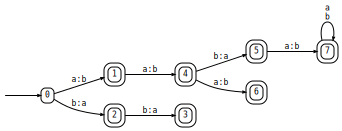

In [1357]:
fst

In [1358]:
for i in fst.states:
   visited = set()
   print(i, check_safe(fst, i, visited))

0 True
1 True
2 True
3 True
4 True
5 True
6 True
7 True


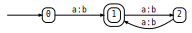

In [1359]:
# machine with infinite remainder for a
fst_ir = FST()
fst_ir.add_arc(0,"a","b",1)
fst_ir.add_arc(1,"a","b",2)
fst_ir.add_arc(2,"a", "b",1)
fst_ir.I.add(0)
fst_ir.F.add(1)
display(fst_ir)


In [1360]:
for i in fst_ir.states:
   print(i, check_safe(fst_ir, i, set()))


0 False
1 False
2 False


In [1361]:
def sty_node(fst, i):
    if is_universal(fst, i):
        return dict(style='filled,rounded', fillcolor='yellow') 
    if check_safe(fst, i, set()):
        return dict(style='filled,rounded', fillcolor='azure')
    else:
        return dict(style='filled', fillcolor='pink') 



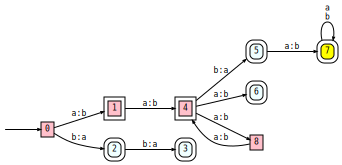

In [1362]:
fst_mod = fst.spawn(keep_arcs=True, keep_init=True, keep_stop=True)
fst_mod.add_arc(4,"a","b",8)
fst_mod.add_arc(8,"a","b",4)
fst_mod.graphviz(sty_node=lambda x: sty_node(fst_mod, x))

In [1363]:
for i in fst_mod.states:
    u = is_universal(fst_mod, i)
    s = check_safe(fst_mod, i, set())
    print(i, "universal:", u, "safe:", s)

0 universal: False safe: False
1 universal: False safe: False
2 universal: False safe: True
3 universal: False safe: True
4 universal: False safe: False
5 universal: False safe: True
6 universal: False safe: True
7 universal: True safe: True
8 universal: False safe: False


### Check epsilon loops on target

In [1364]:
def check_epsilon_loops_tgt(fst, y):
    # Check epsilon loops
    paths = paths_emitting(fst, y)
    for path in paths:
        final_state = path[-1][-1]
        # allowed on universal since will be sink
        if is_universal(fst, final_state):
            continue
        fst_i = fst.spawn(keep_arcs=True, keep_init=False, keep_stop=True)
        fst_i.add_I(final_state)
        fst_i = fst_i.trim()
        if has_eps_cycle(fst_i):
            return True
    return False

In [1365]:
check_epsilon_loops_tgt(fst, "bba")

False

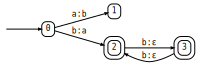

In [1366]:
fst_e = FST()
fst_e.add_arc(0,"a","b",1)
fst_e.add_arc(0,"b","a",2)
fst_e.add_arc(2,"b",eps,3)
fst_e.add_arc(3,"b",eps,2)

fst_e.I.add(0)
fst_e.F.add(2)
fst_e.F.add(3)
display(fst_e)

In [1367]:
assert not check_epsilon_loops_tgt(fst_e, "b")
assert check_epsilon_loops_tgt(fst_e, "a")

#### making fst total

In [1368]:
def make_total(fst, sink_output=eps, sink_final=True):
    m = fst.spawn(keep_init=True, keep_arcs=True, keep_stop=True)
    alphabet = {a for a in m.A if a != eps}

    sink = SINK

    if sink_final:
        m.add_F(sink)

    for a in alphabet:
        m.add_arc(sink, a, sink_output, sink)

    for q in list(m.states):
        have = {a for (a, _, _) in m.arcs(q) if a != eps}
        missing = alphabet - have
        for a in missing:
            m.add_arc(q, a, sink_output, sink)

    return m


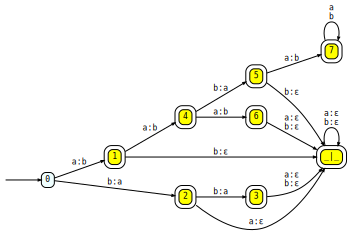

In [1369]:
fst_tot = make_total(fst)

fst_tot.graphviz(sty_node=lambda x: sty_node(fst_tot, x))

### Checking for finite decomposition

In [1370]:
def check_finite_precover_decomp(fst, y):

    assert not check_epsilon_loops_tgt(fst, y), "Has epsilon loop"

    paths = paths_emitting(fst, y)
    assert len(paths) < 9999, "To many paths?"

    for path in paths:
        end = path[-1][-1]
        assert check_safe(fst, end, set()), "not safe"

    return True



In [1371]:
check_finite_precover_decomp(fst, "bb")

True

In [1372]:
def has_input_cycle_fsa(fst):
    sccs = fst.strongly_connected_components()

    comp_id = {}
    for cid, comp in enumerate(sccs):
        for q in comp:
            comp_id[q] = cid

    n = len(sccs)
    size = [len(comp) for comp in sccs]
    has_self_loop = [False] * n
    has_non_eps_arc = [False] * n

    for i in fst.states:
        cid = comp_id[i]
        for a, j in fst.arcs(i):
            if comp_id[j] != cid:
                continue

            if i == j:
                has_self_loop[cid] = True
            if a != eps:
                has_non_eps_arc[cid] = True

    for cid in range(n):
        if has_non_eps_arc[cid] and (size[cid] > 1 or has_self_loop[cid]):
            return True

    return False

In [1373]:
def confirm_finite_precover_decomp(fst, prf):
    pc = Precover(fst, prf)
    q, r = pc.decomposition
    return not has_input_cycle_fsa(q) and not has_input_cycle_fsa(r)


In [1374]:
confirm_finite_precover_decomp(fst, "bb")

True

In [1375]:
import tqdm

def check_prefixes(fst, max_length=10, pb=True):
    fsa = fst.project(0)
    total = sum(len(fst.A)**k for k in range(max_length + 1)) - 1
    has_finite_prf = False
    lang = fsa.language(max_length)
    if pb:
        lang = tqdm.tqdm(lang, total=total)
    for prf in lang:
        finite_lemma = False
        error = None
        try:
            finite_lemma = check_finite_precover_decomp(fst, prf)
        except AssertionError as e:
            error = e
        finite_comfirm = confirm_finite_precover_decomp(fst, prf)
        assert finite_lemma == finite_comfirm, error
        if finite_lemma:
            has_finite_prf = True
    return True, has_finite_prf

In [1376]:
check_prefixes(fst)

  0%|          | 0/2046 [00:00<?, ?it/s]

  7%|▋         | 133/2046 [00:00<00:00, 5650.87it/s]


(True, True)

In [1377]:
check_prefixes(fst_mod)

  9%|▉         | 182/2046 [00:00<00:00, 5320.09it/s]


(True, True)

In [1378]:
check_prefixes(fst_tot)

  0%|          | 0/2046 [00:00<?, ?it/s]

100%|██████████| 2046/2046 [00:00<00:00, 4433.92it/s]


(True, True)

### Sample machines

In [1379]:
import numpy as np
rng = np.random.default_rng(10)

In [1380]:
def sample_fst(A_sz, B_sz, Q_sz, p_arc=None, p_acc=None, p_fin=None, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    fst = FST()
  
    if p_arc is None:
        p_arc = 0.2
    if p_acc is None:
        p_acc = 0.1
    if p_fin is None:
        p_fin = 0.1


    states = list(range(Q_sz))
    A = list(range(A_sz))
    B = list(range(B_sz))

    for q in states:
        fst.states.add(q)

    for q in states:
        if rng.random() < p_acc:
            fst.add_I(q)
        if rng.random() < p_fin:
            fst.add_F(q)

    if not fst.I:
        fst.add_I(0)
    if not fst.F:
        fst.add_F(Q_sz - 1)

    for q in states:
        mask = rng.random(A_sz) < p_arc
        if not mask.any():
            continue

        targets = rng.integers(0, Q_sz, size=A_sz)
        outputs = rng.integers(0, B_sz, size=A_sz)

        for a_idx, has_arc in enumerate(mask):
            if not has_arc:
                continue
            a = A[a_idx]
            b = B[outputs[a_idx]]
            q2 = states[targets[a_idx]]
            fst.add_arc(q, str(a), str(b), q2)
            
    fst = fst.trim()
    if not fst.states:
        return sample_fst(A_sz, B_sz, Q_sz, p_arc, p_acc, p_fin, rng)
    return fst


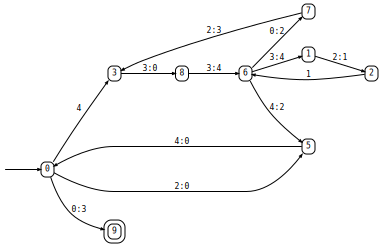

In [1381]:
rfst = sample_fst(5,5,10,rng=rng)
#rfst = make_total(rfst)
rfst

In [1382]:
check_prefixes(rfst)

  0%|          | 13/12207030 [00:00<1:04:41, 3144.52it/s]


(True, True)

In [1383]:
from collections import defaultdict
stats = defaultdict(int)
for i in tqdm.tqdm(range(1000)):
    rfst = sample_fst(5,5,10, rng=rng)
    ok, lemma = check_prefixes(rfst, pb=False)
    assert ok
    stats[lemma] += 1
print(stats)
    

  0%|          | 0/1000 [00:00<?, ?it/s]


TypeError: 'int' object is not subscriptable

### We can also enumerate

This is a bit crazy

In [ ]:
from itertools import product


def enumerate_fsts(A_sz, B_sz, Q_sz):

    states = list(range(Q_sz))
    inputs = list(range(A_sz))
    outputs = list(range(B_sz))

    per_pair_options = [None] + [
        (b, q2) for b in outputs for q2 in states
    ]
    num_pairs = Q_sz * A_sz

    # Subsets of states are represented as bitmasks 0..2^Q_sz-1
    for init_mask in range(1 << Q_sz):
        init_set = {q for q in states if (init_mask >> q) & 1}
        if not init_set:
            continue

        for fin_mask in range(1 << Q_sz):
            fin_set = {q for q in states if (fin_mask >> q) & 1}
            if not fin_set:
                continue

            # All choices for arcs
            for combo_idxs in product(range(len(per_pair_options)), repeat=num_pairs):
                fst = FST()

                for q in states:
                    fst.states.add(q)

                for q in init_set:
                    fst.add_I(q)
                for q in fin_set:
                    fst.add_F(q)

                idx = 0
                for q in states:
                    for a in inputs:
                        choice = per_pair_options[combo_idxs[idx]]
                        idx += 1
                        if choice is None:
                            continue
                        b, q2 = choice
                        fst.add_arc(q, str(a), str(b), q2)

                fst = fst.trim()
                if not fst.states:
                    continue

                yield fst


In [ ]:
stats = defaultdict(int)
Q_sz = 2
total = ((2**Q_sz-1)**2 ) * (1+2*Q_sz)**(2*Q_sz)

for i, enumfst in tqdm.tqdm(enumerate(enumerate_fsts(A_sz=2, B_sz=2, Q_sz=Q_sz)), total=total):
    if i % 12:
        # to long to do all.. we could pickle and multiprocess
        continue
    try:
        ok, lemma = check_prefixes(enumfst, pb=False)
    except Exception as e:
        display(enumfst)
        raise e
    assert ok
    stats[lemma] += 1

print(stats)
    

 12%|█▏        | 672/5625 [00:06<00:47, 105.35it/s]


KeyboardInterrupt: 

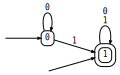

  0%|          | 0/2046 [00:00<?, ?it/s]


IndexError: list index out of range

In [1386]:
fst_t = FST()
fst_t.add_arc(0,"0","0",0)
fst_t.add_arc(0,"1","1",1)
fst_t.add_arc(1,"1","1",1)
fst_t.add_arc(1,"0","0",1)
fst_t.F.add(1)
fst_t.I = {0,1}
display(fst_t)
check_prefixes(fst_t)